# Predicting the pandemic with Random Forests

In this notebook we are learning how to use random forest models in order to model the COVID19 pandemic and make forecasts.

In [1]:
# Define data paths (update these to match your local setup)
data_relative_dir_path = "/Users/ashok/Documents/ABROAD-NEW-INTAKE/SRH-MUNICH/COURSE-&-CLASS-RESOURCES/INTRO-ML/rki-merged-data/"

# File paths
owid_path = data_relative_dir_path + "compact.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# 1. LOAD & ENGINEER DATA (Recap)
# url = "data/owid_compact.csv"
url = owid_path
df = pd.read_csv(url)

df['date'] = pd.to_datetime(df['date'])
df = df[df['country'] == 'United Kingdom'].set_index('date').sort_index()

# df = df.loc['2020-10-01':'2022-01-01', ['excess_mortality', 'reproduction_rate', 'icu_patients', 'new_cases', 'new_deaths', 'hosp_patients', 'people_fully_vaccinated_per_hundred']].fillna(0)

df = df.loc['2020-01-01':'2022-03-01', [
    'excess_mortality',
    'reproduction_rate',
    'icu_patients',
    'people_fully_vaccinated_per_hundred',
    'hosp_patients',
    'new_deaths',
    'new_cases',
    'stringency_index',
    'gdp_per_capita',
    'population_density'
]].copy()



# Handle weekly-reported excess_mortality
# Strategy: Distribute weekly totals evenly across 7 days

print("📊 Processing weekly excess_mortality reports...")

# Preserve original reported values for audit
df['excess_mortality_reported'] = df['excess_mortality'].copy()

# Identify weekly report pattern (value on 7th day, NaN on previous 6)
reported_mask = (
    df['excess_mortality'].notna() &
    df['excess_mortality'].shift(1).isna() &
    df['excess_mortality'].shift(2).isna() &
    df['excess_mortality'].shift(3).isna() &
    df['excess_mortality'].shift(4).isna() &
    df['excess_mortality'].shift(5).isna() &
    df['excess_mortality'].shift(6).isna()
)

# Distribute weekly values to daily
for idx in df[reported_mask].index:
    total = df.at[idx, 'excess_mortality']
    daily = total / 7.0
    
    # Fill the 7-day window ending at idx
    for d in range(0, 7):
        day = idx - pd.Timedelta(days=6 - d)
        if day in df.index:
            df.at[day, 'excess_mortality'] = daily

# Interpolate any remaining NaN values
df['excess_mortality'] = df['excess_mortality'].interpolate(method='time')

print(f"✅ Excess mortality processed")
print(f"   Missing values after processing: {df['excess_mortality'].isnull().sum()}")



print("🔧 Creating temporal features with biological delays...\n")
 
# Current indicators
df['reproduction_rate_current'] = df['reproduction_rate'].fillna(0)
df['stringency'] = df['stringency_index'].fillna(0)
 
# 🔧 FIX #1: Fill vaccination rate with 0 (pre-vaccine era)
df['vaccination_rate'] = df['people_fully_vaccinated_per_hundred'].fillna(0)
print(f"✅ Vaccination rate: {df['vaccination_rate'].isnull().sum()} NaN (fixed with 0)")
 
# Lagged features (14-day biological delay)
df['hosp_patients_lag_14'] = df['hosp_patients'].shift(14)
df['icu_patients_lag_14'] = df['icu_patients'].shift(14)
df['cases_lag_14'] = df['new_cases'].shift(14)
print(f"   Hospital lag 14d: {df['hosp_patients_lag_14'].isnull().sum()} NaN (first 14 days)")
 
# additional updates
df['new_deaths_lag_14'] = df['new_deaths'].shift(14)
df['icu_patients_lag_14_filled'] = df['icu_patients_lag_14'].fillna(0)
 
# Rolling averages (smooth weekend effects)
df['deaths_trend_14'] = df['new_deaths'].rolling(14).mean()
df['cases_trend_7'] = df['new_cases'].rolling(7).mean()
print(f"   Deaths trend 14d: {df['deaths_trend_14'].isnull().sum()} NaN (first 13 days)")
 
# Static features
df['gdp_per_capita'] = df['gdp_per_capita']
df['population_density'] = df['population_density']
 
print("\n✅ Feature engineering complete")

# df = df.dropna()
df = df.fillna(0)

# 2. SPLIT DATA (Time-Based)
# --------------------------
# Train on Waves 1-3, Test on Omicron
cutoff = '2021-11-01'
# features = ['cases_lag_14', 'velocity', 'cases_smooth_7', 'day_of_week', 'hosp_lag_7', 'hosp_lag_14']

features = [
    # 'reproduction_rate_current',
    'vaccination_rate',
    'hosp_patients_lag_14',
    'deaths_trend_14',
    'icu_patients_lag_14_filled',
    'new_deaths_lag_14',
    # 'new_deaths',
    'stringency'
   
   
]

# Compare: raw vs smoothed target
#target_raw = 'new_deaths'
# target_smooth = 'deaths_smooth_7'
target_smooth = 'excess_mortality'

train = df[df.index < cutoff]
test = df[df.index >= cutoff]

X_train, y_train = train[features], train[target_smooth]
X_test, y_test = test[features], test[target_smooth]

print(f"Training Days: {len(X_train)}, Testing Days: {len(X_test)}")


📊 Processing weekly excess_mortality reports...
✅ Excess mortality processed
   Missing values after processing: 0
🔧 Creating temporal features with biological delays...

✅ Vaccination rate: 0 NaN (fixed with 0)
   Hospital lag 14d: 105 NaN (first 14 days)
   Deaths trend 14d: 16 NaN (first 13 days)

✅ Feature engineering complete
Training Days: 670, Testing Days: 121


Data ready for advanced machine learning models. Rows: 791


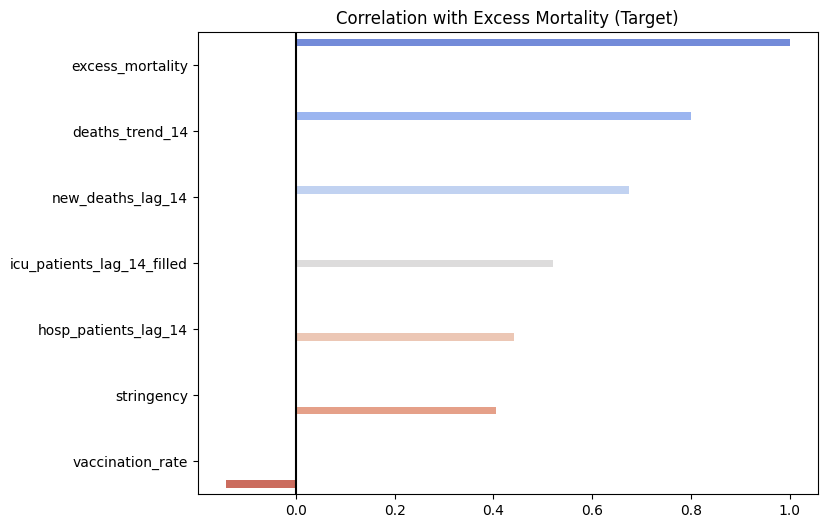

In [3]:
# 🔧 FIX: Use df_clean (from Cell 17) instead of df.dropna()
df_clean = df.dropna()
target = target_smooth
df_model = df_clean[features + [target]].copy()

print(f"Data ready for advanced machine learning models. Rows: {len(df_model)}")

# CHECK: Which feature is actually best?
# We correlate everything with our target ('excess_mortality')
corr = df_model.corr()['excess_mortality'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr.values, y=corr.index, hue=corr.index, palette='coolwarm')
plt.legend([],[], frameon=False)
plt.title("Correlation with Excess Mortality (Target)")
plt.axvline(0, color='black')
plt.show()

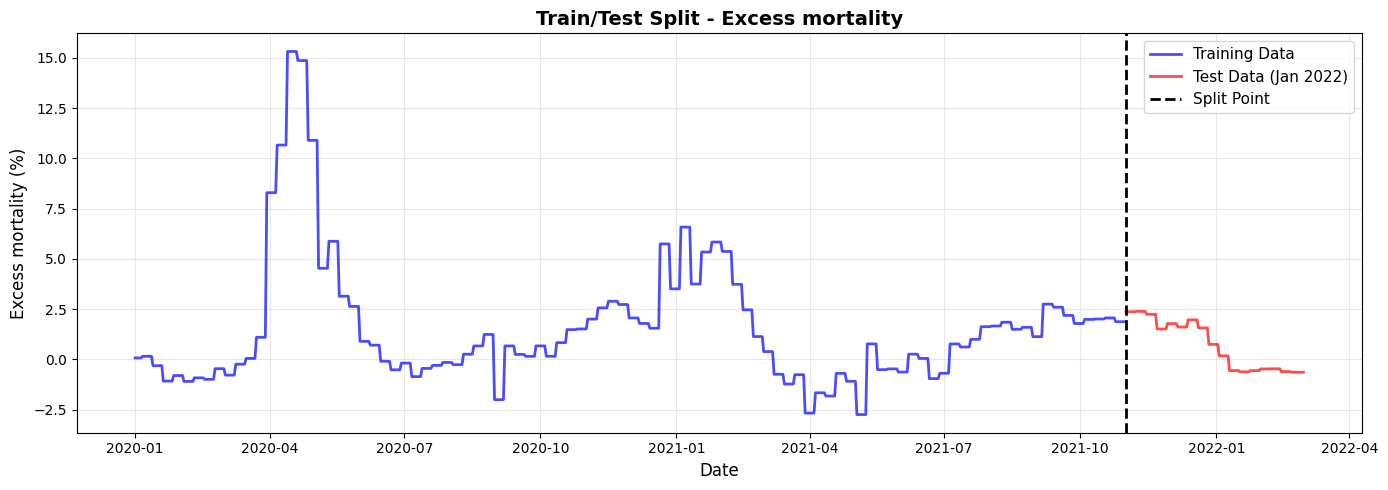

In [4]:

target = target_smooth
target_label = target_smooth.replace('_', ' ').replace('-', ' ').capitalize()


# Visualize the split
plt.figure(figsize=(14, 5))
plt.plot(train.index, train[target], 'b-', linewidth=2, label='Training Data', alpha=0.7)
plt.plot(test.index, test[target], 'r-', linewidth=2, label='Test Data (Jan 2022)', alpha=0.7)
plt.axvline(pd.Timestamp(cutoff), color='black', linestyle='--', linewidth=2, label='Split Point')
plt.title(f'Train/Test Split - {target_label}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{target_label} (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 1. Baseline Model (Linear Regression)

### Goal: Establish performance benchmark
Advanced models must beat this simple baseline!

In [5]:
print("📊 Training Baseline: Linear Regression\n")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr.predict(X_train)
y_pred_lr_test = lr.predict(X_test)

# Metrics
mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)
mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
r2_lr_test = r2_score(y_test, y_pred_lr_test)

print(f"✅ Linear Regression Results:")
print(f"   Train MAE: {mae_lr_train:.3f}")
print(f"   Test MAE:  {mae_lr_test:.3f} ⭐ BASELINE")
print(f"   Test RMSE: {rmse_lr_test:.3f}")
print(f"   Test R²:   {r2_lr_test:.3f}")

📊 Training Baseline: Linear Regression

✅ Linear Regression Results:
   Train MAE: 0.842
   Test MAE:  0.624 ⭐ BASELINE
   Test RMSE: 0.705
   Test R²:   0.655


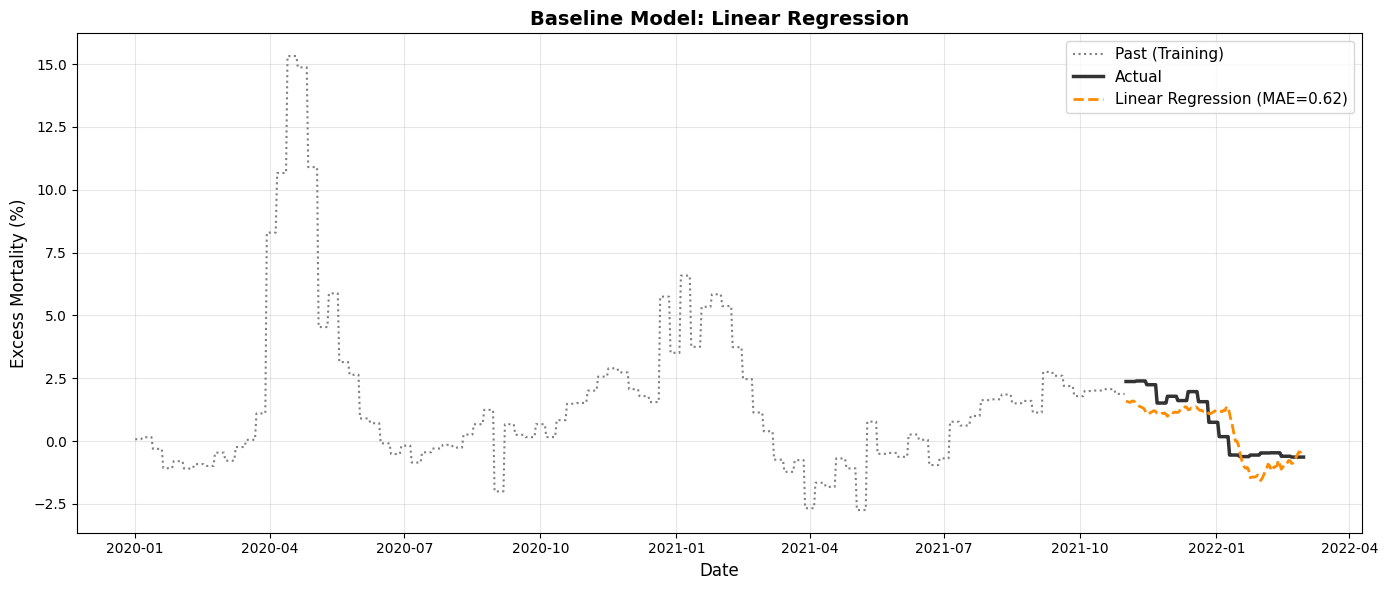

In [6]:
# Visualize baseline predictions
plt.figure(figsize=(14, 6))

# Plot the Past (Training Data) - Optional, for context
plt.plot(train.index, train[target], color='gray', linestyle=':', label='Past (Training)')

plt.plot(test.index, y_test, 'k-', linewidth=2.5, label='Actual', alpha=0.8)
plt.plot(test.index, y_pred_lr_test, color='darkorange', linestyle='--', linewidth=2, label=f'Linear Regression (MAE={mae_lr_test:.2f})')
plt.title('Baseline Model: Linear Regression', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Excess Mortality (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 2. Decision Tree (Depth Analysis)

### Experiment: Finding optimal tree depth
- Shallow trees underfit
- Deep trees overfit
- Goal: Find the "Goldilocks zone"

Now let's find how the depth of the decision tree influences its accuracy...

       Train MAE  Test MAE
Depth                     
1       1.531683  1.141994
2       1.203316  1.287255
3       0.820983  1.201607
4       0.548450  1.363929
8       0.180965  0.932059
16      0.014051  0.928598
32      0.014051  0.928598
None    0.014051  0.928598


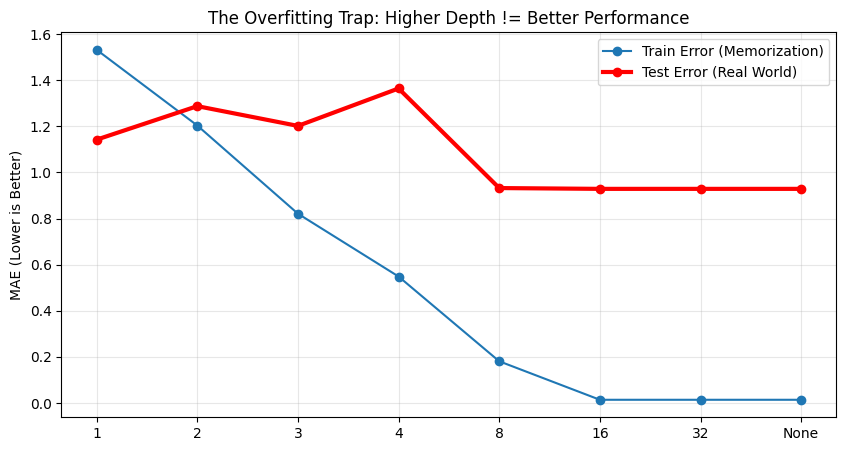

In [7]:
# THE EXPERIMENT: DEPTH SWEEP 
depths = [1, 2, 3, 4, 8, 16, 32, None]
results = []

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    
    train_mae = mean_absolute_error(y_train, dt.predict(X_train))
    test_mae = mean_absolute_error(y_test, dt.predict(X_test))
    
    results.append({'Depth': str(d), 'Train MAE': train_mae, 'Test MAE': test_mae})

# Convert to DataFrame and Plot
res_df = pd.DataFrame(results).set_index('Depth')
print(res_df)

plt.figure(figsize=(10, 5))
plt.plot(res_df.index, res_df['Train MAE'], marker='o', label='Train Error (Memorization)')
plt.plot(res_df.index, res_df['Test MAE'], marker='o', color='red', linewidth=3, label='Test Error (Real World)')
plt.ylabel("MAE (Lower is Better)")
plt.title("The Overfitting Trap: Higher Depth != Better Performance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [8]:
# Step B: Decision Tree - Use depth 8 (balanced)
dt = DecisionTreeRegressor(max_depth=8, random_state=42)
dt.fit(X_train, y_train)
mae_dt = mean_absolute_error(y_test, dt.predict(X_test))

# Step C: Random Forest - Tune based on depth experiment
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,  # Changed from None to 8 (prevents overfitting)
    min_samples_leaf=5,
    min_samples_split=10,  # Increased from 5 (more conservative)
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
mae_rf = mean_absolute_error(y_test, rf.predict(X_test))

# Step D: XGBoost - Add depth control
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=1000,
    # max_depth=6,  # Add depth limit (XGBoost default is 6)
    learning_rate=0.05,
    # min_child_weight=5,  # Similar to min_samples_leaf
    # subsample=0.8,  # Use 80% of data per tree (reduces overfitting)
    # colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

Let's see how a random forest performs in comparison...

Linear MAE:        0.62
Decision Tree MAE: 0.93
Random Forest MAE: 1.17
XGBoost MAE:       1.00


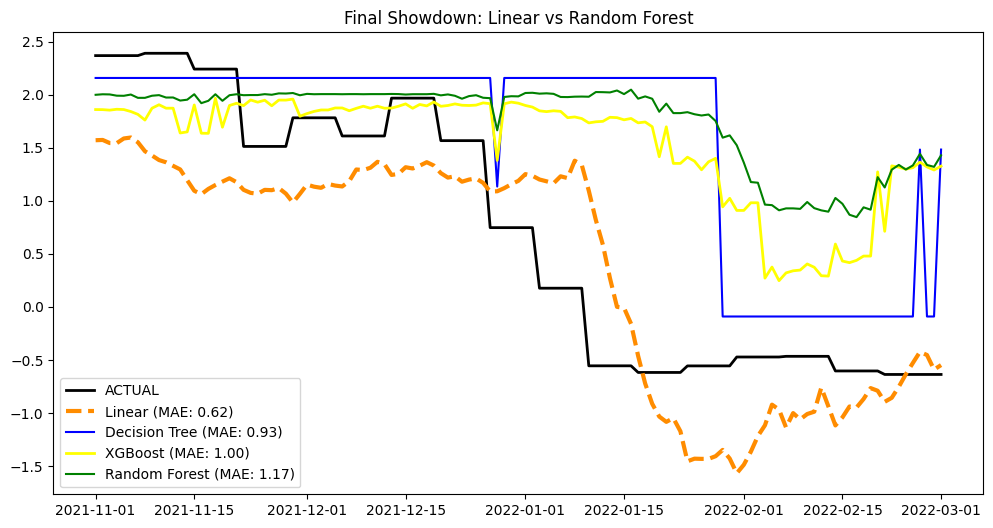

In [9]:
mae_lr = mae_lr_test

# Step A: Baseline (Linear Regression)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# mae_lr = mean_absolute_error(y_test, lr.predict(X_test))

# # Step B: Decision Tree
# dt = DecisionTreeRegressor(max_depth=10, random_state=42)
# dt.fit(X_train, y_train)
# mae_dt = mean_absolute_error(y_test, dt.predict(X_test))

# # Step C: Random Forest
# rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_leaf=5, min_samples_split=5, random_state=42)
# rf.fit(X_train, y_train)
# mae_rf = mean_absolute_error(y_test, rf.predict(X_test))

# # Step D: XGBoost
# print("Training XGBoost...")
# from xgboost import XGBRegressor
# xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)
# xgb.fit(X_train, y_train)

# EVALUATE
# # -----------
pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, pred_xgb)

# Note: `y_test` is actual value of target variable

print(f"Linear MAE:        {mae_lr:.2f}") 
print(f"Decision Tree MAE: {mae_dt:.2f}") 
print(f"Random Forest MAE: {mae_rf:.2f}") 
print(f"XGBoost MAE:       {mae_xgb:.2f}")

# Visualization
pred_rf = rf.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, color='black', label='ACTUAL', linewidth=2)
plt.plot(test.index, lr.predict(X_test), color='darkorange', linewidth=3, linestyle='--', label=f'Linear (MAE: {mae_lr:.2f})')
plt.plot(test.index, dt.predict(X_test), color='blue', label=f'Decision Tree (MAE: {mae_dt:.2f})')

plt.plot(test.index, pred_xgb, color='yellow', linewidth=2, label=f'XGBoost (MAE: {mae_xgb:.2f})')


plt.plot(test.index, pred_rf, color='green', label=f'Random Forest (MAE: {mae_rf:.2f})')
plt.title("Final Showdown: Linear vs Random Forest")
plt.legend()
plt.show()



# Opening the black box
# ---------------------

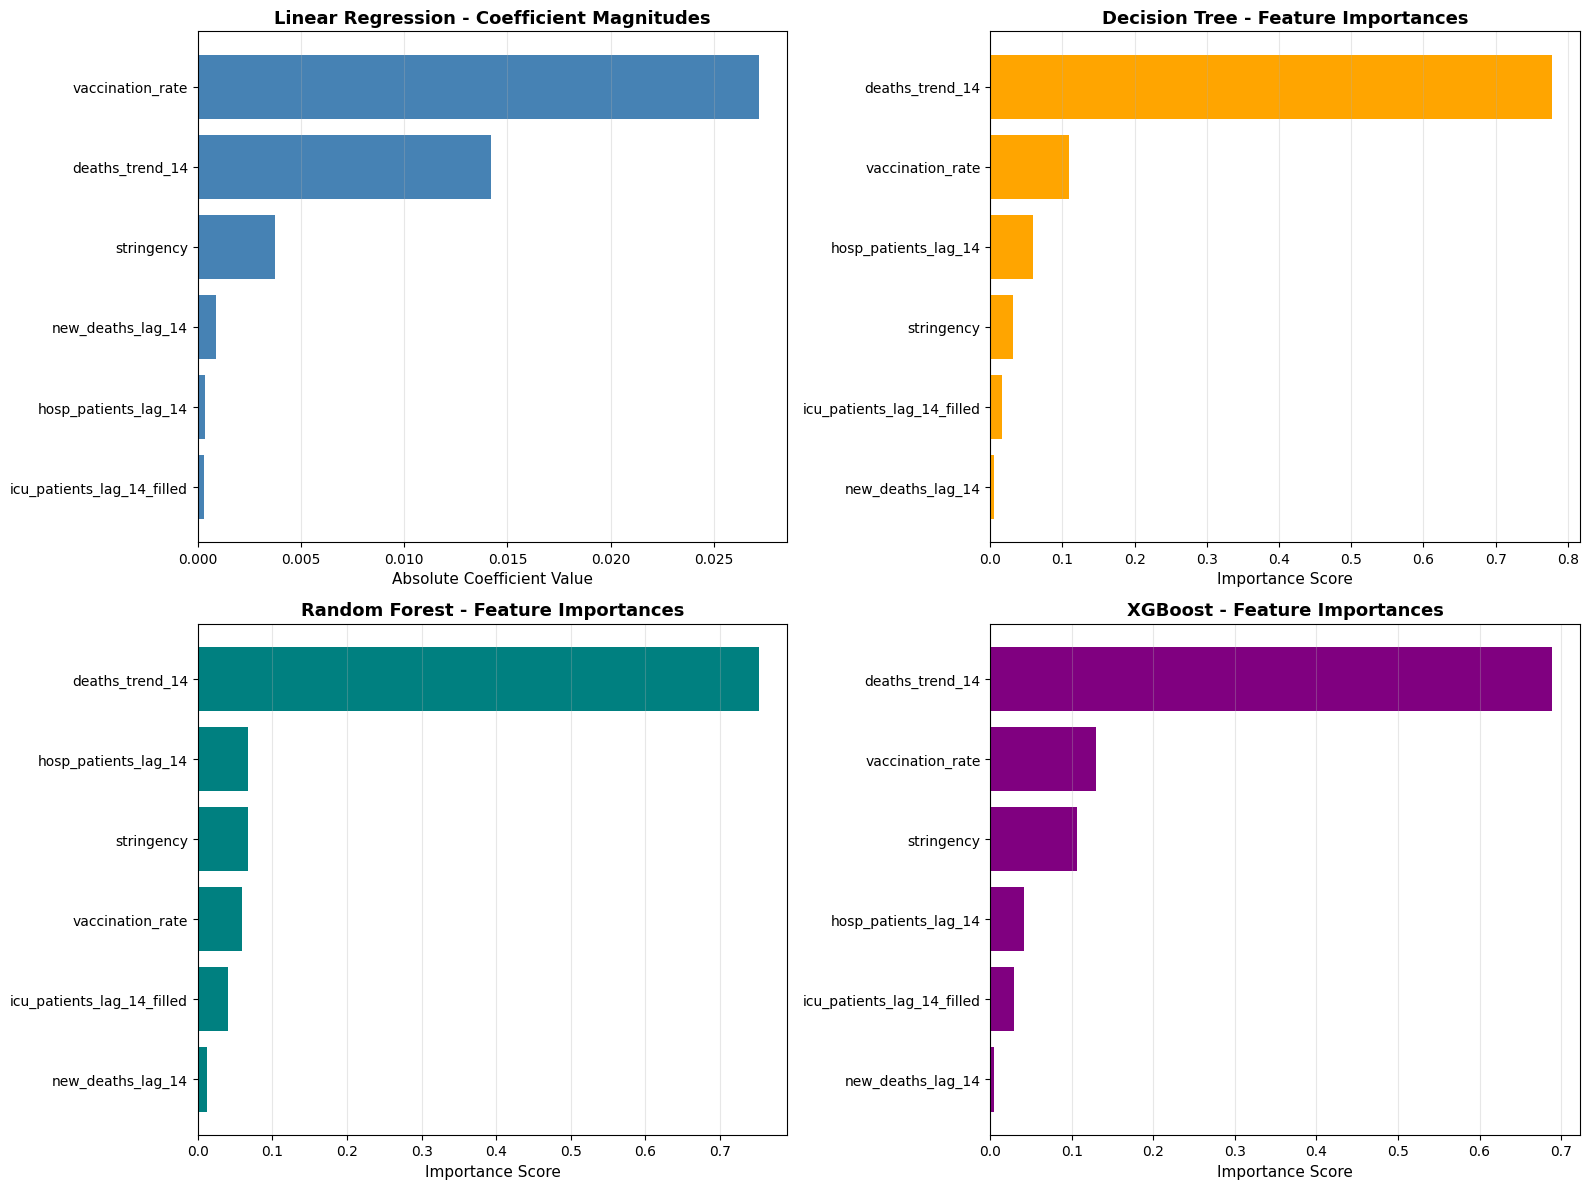


FEATURE IMPORTANCE RANKINGS ACROSS ALL MODELS
                            Linear Reg  Decision Tree  Random Forest  XGBoost  \
deaths_trend_14                      2              1              1        1   
vaccination_rate                     1              2              4        2   
stringency                           3              4              3        3   
hosp_patients_lag_14                 5              3              2        4   
icu_patients_lag_14_filled           6              5              5        5   
new_deaths_lag_14                    4              6              6        6   

                            Avg Rank  
deaths_trend_14                 1.25  
vaccination_rate                2.25  
stringency                      3.25  
hosp_patients_lag_14            3.50  
icu_patients_lag_14_filled      5.25  
new_deaths_lag_14               5.50  

🏆 TOP 3 MOST IMPORTANT FEATURES (by average rank):
   1. deaths_trend_14 (Avg Rank: 1.2)
   2. vaccination_rate

In [10]:
# # Opening the black box
# # ---------------------
# importances = pd.Series(rf.feature_importances_, index=features).sort_values()

# plt.figure(figsize=(8, 4))
# importances.plot(kind='barh', color='teal')
# plt.title("What matters most?")
# plt.xlabel("Feature Importance")
# plt.show()


# Feature Importance Comparison: All Models
# -----------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Linear Regression - Coefficient Magnitudes
lr_importances = pd.Series(np.abs(lr.coef_), index=features).sort_values()
axes[0, 0].barh(lr_importances.index, lr_importances.values, color='steelblue')
axes[0, 0].set_title('Linear Regression - Coefficient Magnitudes', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Absolute Coefficient Value', fontsize=11)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Decision Tree - Feature Importances
dt_importances = pd.Series(dt.feature_importances_, index=features).sort_values()
axes[0, 1].barh(dt_importances.index, dt_importances.values, color='orange')
axes[0, 1].set_title('Decision Tree - Feature Importances', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Importance Score', fontsize=11)
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Random Forest - Feature Importances
rf_importances = pd.Series(rf.feature_importances_, index=features).sort_values()
axes[1, 0].barh(rf_importances.index, rf_importances.values, color='teal')
axes[1, 0].set_title('Random Forest - Feature Importances', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Importance Score', fontsize=11)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. XGBoost - Feature Importances
xgb_importances = pd.Series(xgb.feature_importances_, index=features).sort_values()
axes[1, 1].barh(xgb_importances.index, xgb_importances.values, color='purple')
axes[1, 1].set_title('XGBoost - Feature Importances', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Importance Score', fontsize=11)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Table: Feature Rankings Across Models
print("\n" + "="*80)
print("FEATURE IMPORTANCE RANKINGS ACROSS ALL MODELS")
print("="*80)

importance_df = pd.DataFrame({
    'Linear Reg': lr_importances.rank(ascending=False).astype(int),
    'Decision Tree': dt_importances.rank(ascending=False).astype(int),
    'Random Forest': rf_importances.rank(ascending=False).astype(int),
    'XGBoost': xgb_importances.rank(ascending=False).astype(int)
})

# Sort by Random Forest ranking (or average ranking)
importance_df['Avg Rank'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values('Avg Rank')

print(importance_df)
print("="*80)

# Top 3 features by model consensus
print("\n🏆 TOP 3 MOST IMPORTANT FEATURES (by average rank):")
for i, (feat, row) in enumerate(importance_df.head(3).iterrows(), 1):
    print(f"   {i}. {feat} (Avg Rank: {row['Avg Rank']:.1f})")

print("\n💡 Interpretation:")
print("   - Lower rank = More important (1 is most important)")
print("   - Consensus across models indicates robust feature importance")
print("   - Linear Reg uses coefficient magnitudes (different scale)")
print("="*80)

Also let's compare with a gradient boosted tree...

Training XGBoost...
Random Forest MAE: 1.17
XGBoost MAE:       1.00
✅ XGBoost wins! It squeezed out more accuracy.


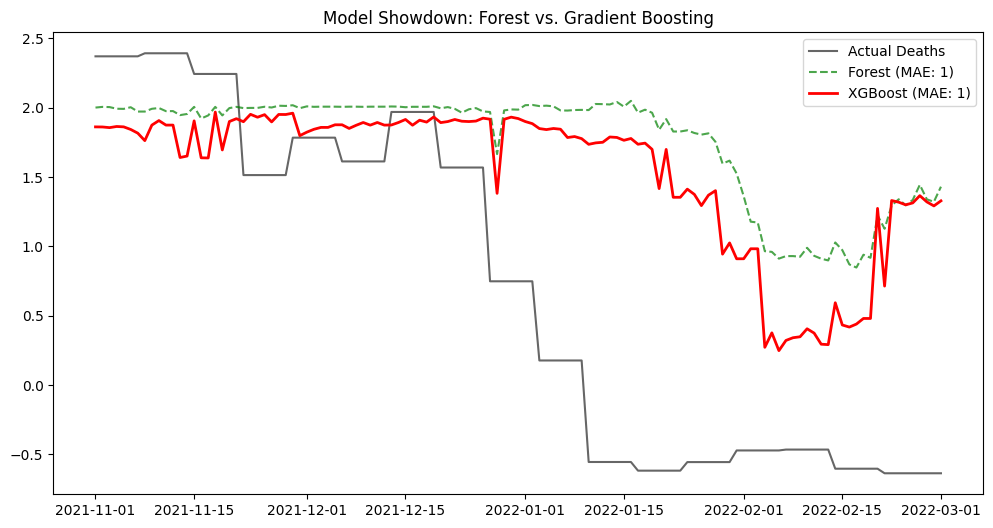

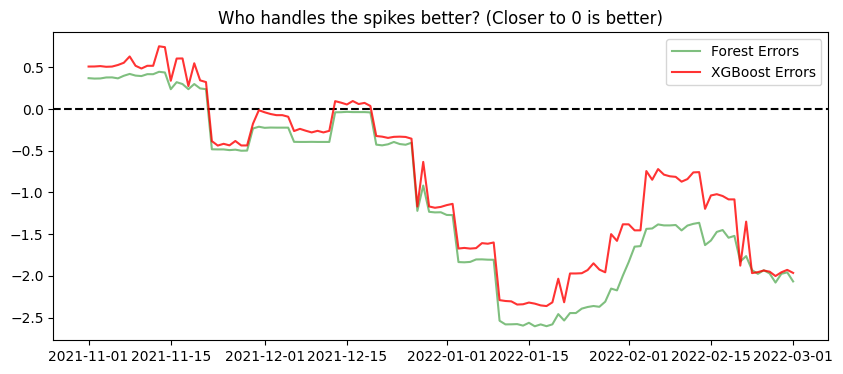

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

# TRAIN THE MODEL 
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)

print("Training XGBoost...")
xgb.fit(X_train, y_train)

# EVALUATE
# -----------
pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, pred_xgb)

print(f"Random Forest MAE: {mae_rf:.2f}") # From previous notebook
print(f"XGBoost MAE:       {mae_xgb:.2f}")

if mae_xgb < mae_rf:
    print("✅ XGBoost wins! It squeezed out more accuracy.")
else:
    print("❌ Tie/Loss. (XGBoost often needs more tuning to beat a Forest).")

# VISUALIZE
plt.figure(figsize=(12, 6))

# Plot Actual Data
plt.plot(test.index, y_test, color='black', alpha=0.6, label='Actual Deaths')

# Plot Random Forest (Green)
plt.plot(test.index, pred_rf, color='green', linestyle='--', alpha=0.7, label=f'Forest (MAE: {mae_rf:.0f})')

# Plot XGBoost (Red)
plt.plot(test.index, pred_xgb, color='red', linewidth=2, label=f'XGBoost (MAE: {mae_xgb:.0f})')

plt.title("Model Showdown: Forest vs. Gradient Boosting")
plt.legend()
plt.show()

# EXPLAINING THE "WHY" (Residual Plot)
# ---------------------------------------
# Let's see the errors. XGBoost should have smaller residuals on the "spikes".
residuals_rf = y_test - pred_rf
residuals_xgb = y_test - pred_xgb

plt.figure(figsize=(10, 4))
plt.axhline(0, color='black', linestyle='--')
plt.plot(test.index, residuals_rf, color='green', alpha=0.5, label='Forest Errors')
plt.plot(test.index, residuals_xgb, color='red', alpha=0.8, label='XGBoost Errors')
plt.title("Who handles the spikes better? (Closer to 0 is better)")
plt.legend()
plt.show()

## COMPREHENSIVE MODEL PERFORMANCE COMPARISON


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, y_true, y_pred):
    """Calculate all key metrics for a model"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE - avoid division by zero
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    return {
        'Model': name,
        'MAE ↓': f'{mae:.3f}',
        'RMSE ↓': f'{rmse:.3f}',
        'R² ↑': f'{r2:.3f}',
        'MAPE % ↓': f'{mape:.2f}'
    }
    
    
    

# Evaluate all models
results = []
results.append(evaluate_model('Linear Regression', y_test, lr.predict(X_test)))
results.append(evaluate_model('Decision Tree', y_test, dt.predict(X_test)))
results.append(evaluate_model('Random Forest', y_test, rf.predict(X_test)))
results.append(evaluate_model('XGBoost', y_test, xgb.predict(X_test)))

# Create comparison table
comparison_df = pd.DataFrame(results)
print(comparison_df.round(3))
print("\n" + "="*70)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Find best model per metric
print("\n🏆 BEST MODEL PER METRIC:")

# Quick fix - convert to numeric directly
print(f"   • Lowest MAE:  {comparison_df.loc[pd.to_numeric(comparison_df['MAE ↓']).idxmin(), 'Model']}")
print(f"   • Lowest RMSE: {comparison_df.loc[pd.to_numeric(comparison_df['RMSE ↓']).idxmin(), 'Model']}")
print(f"   • Highest R²:  {comparison_df.loc[pd.to_numeric(comparison_df['R² ↑']).idxmax(), 'Model']}")
print(f"   • Lowest MAPE: {comparison_df.loc[pd.to_numeric(comparison_df['MAPE % ↓'].str.replace('%', '')).idxmin(), 'Model']}")

print("\n💡 INTERPRETATION:")
print("   ↓ = Lower is better  |  ↑ = Higher is better")
print("   • MAE: Average absolute error")
print("   • RMSE: Penalizes large errors more than MAE")
print("   • R²: Variance explained (closer to 1.0 is better)")
print("   • MAPE: Percentage error (easier to interpret)")
print("="*70)

               Model  MAE ↓ RMSE ↓    R² ↑ MAPE % ↓
0  Linear Regression  0.624  0.705   0.655    96.12
1      Decision Tree  0.932  1.307  -0.184   184.94
2      Random Forest  1.166  1.447  -0.450   226.76
3            XGBoost  1.003  1.246  -0.076   191.29

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
            Model MAE ↓ RMSE ↓   R² ↑ MAPE % ↓
Linear Regression 0.624  0.705  0.655    96.12
    Decision Tree 0.932  1.307 -0.184   184.94
    Random Forest 1.166  1.447 -0.450   226.76
          XGBoost 1.003  1.246 -0.076   191.29

🏆 BEST MODEL PER METRIC:
   • Lowest MAE:  Linear Regression
   • Lowest RMSE: Linear Regression
   • Highest R²:  Linear Regression
   • Lowest MAPE: Linear Regression

💡 INTERPRETATION:
   ↓ = Lower is better  |  ↑ = Higher is better
   • MAE: Average absolute error
   • RMSE: Penalizes large errors more than MAE
   • R²: Variance explained (closer to 1.0 is better)
   • MAPE: Percentage error (easier to interpret)


/var/folders/yb/mfpcq1nj1_v1m00ygpk5rkj80000gp/T/ipykernel_3733/1073401770.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(models, rotation=45, ha='right')


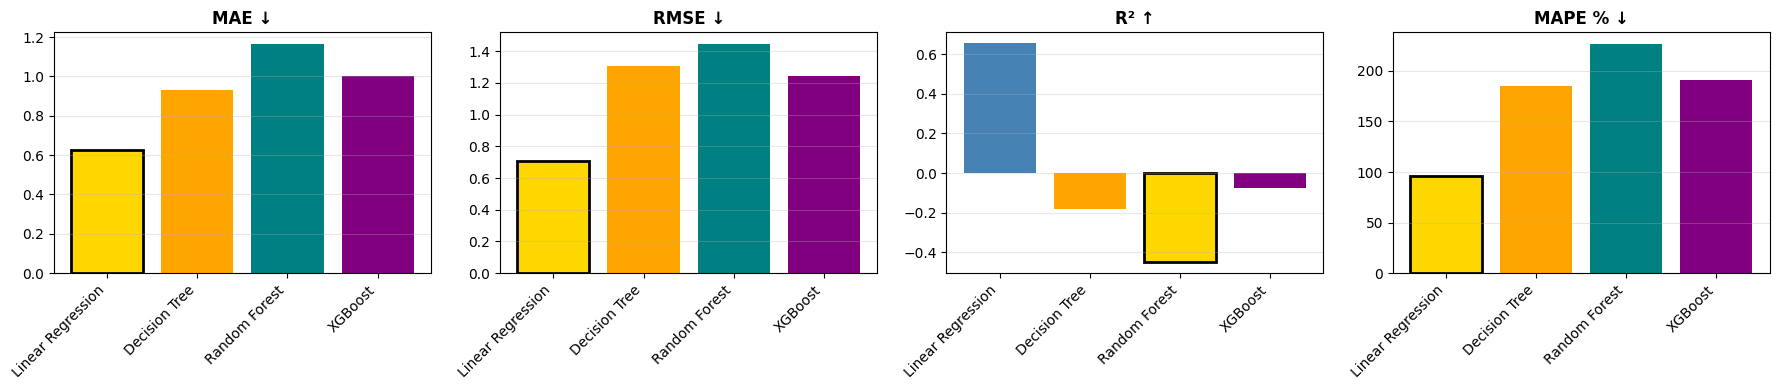

In [13]:
# Visual comparison of all metrics
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

metrics_data = {
    'MAE ↓': [float(r['MAE ↓']) for r in results],
    'RMSE ↓': [float(r['RMSE ↓']) for r in results],
    'R² ↑': [float(r['R² ↑']) for r in results],
    'MAPE % ↓': [float(r['MAPE % ↓'].replace('%', '')) for r in results]
}

models = [r['Model'] for r in results]
colors = ['steelblue', 'orange', 'teal', 'purple']

for idx, (metric, values) in enumerate(metrics_data.items()):
    axes[idx].bar(models, values, color=colors)
    axes[idx].set_title(f'{metric}', fontweight='bold')
    axes[idx].set_xticklabels(models, rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Highlight best
    if metric == 'R²':
        best_idx = np.argmax(values)
    else:
        best_idx = np.argmin(values)
    axes[idx].patches[best_idx].set_facecolor('gold')
    axes[idx].patches[best_idx].set_edgecolor('black')
    axes[idx].patches[best_idx].set_linewidth(2)

plt.tight_layout()
plt.show()